<a href="https://colab.research.google.com/github/sreesriavvaru123/MI/blob/main/MI_CNN_LSTM_v11_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab-compatible notebook for MI detection using PTB-XL with 12-leads and 10-fold CV



## STEP 1: Install necessary packages



In [ ]:
!pip install wfdb scikit-learn matplotlib tensorflow --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 127.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


## STEP 2: Import required libraries


In [ ]:
# CNN-LSTM with Stacking Decoding on PTB-XL (MI, Healthy, Other) - 12-lead Version
# Step 2: Imports
import os
import numpy as np
import pandas as pd
import wfdb
from tqdm import tqdm
from scipy.signal import savgol_filter, resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout, LSTM, Dense
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## STEP 3: Download and unzip PTB-XL data

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI if not already
!pip install -q kaggle

# Download the PTB-XL dataset
!kaggle datasets download -d khyeh0719/ptb-xl-dataset

# Unzip the dataset
!unzip ptb-xl-dataset.zip -d ptb-xl


Streaming output truncated to the last 5000 lines.
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/1934

## STEP 4: Load metadata and diagnostic class mapping

In [ ]:
import pandas as pd

ptbxl_path = "/content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"
print("Loading metadata...")

# Load metadata and SCP diagnostic info
df = pd.read_csv(ptbxl_path + 'ptbxl_database.csv')
class_map = pd.read_csv(ptbxl_path + 'scp_statements.csv', index_col=0)

# Add full path to 100Hz signal files
df['filename_lr'] = ptbxl_path + df['filename_lr']

# Evaluate stringified dict to real dict
df['scp_codes'] = df['scp_codes'].apply(eval)

# Define mapping from SCP codes to 3 classes
def map_3_classes(scp_codes, class_map):
    """
    Maps SCP codes to 3 classes: MI, NORM, OTHER.
    """
    mi_codes = class_map[class_map['diagnostic_class'] == 'MI'].index.tolist()
    norm_codes = class_map[class_map['diagnostic_class'] == 'NORM'].index.tolist()

    for code in scp_codes.keys():
        if code in mi_codes:
            return 'MI'
        if code in norm_codes:
            return 'NORM'

    # If no MI or NORM code is found, return 'OTHER'
    return 'OTHER'

# Apply 3-class mapping
df['class'] = df['scp_codes'].apply(lambda x: map_3_classes(x, class_map))

# Drop rows with unmapped class
df = df[df['class'].notnull()]

# Display class distribution
print("Class distribution:")
print(df['class'].value_counts())

# Final usable dataset
df_multiclass = df[['filename_lr', 'class']]

Loading metadata...
Class distribution:
class
NORM     9528
OTHER    6824
MI       5485
Name: count, dtype: int64


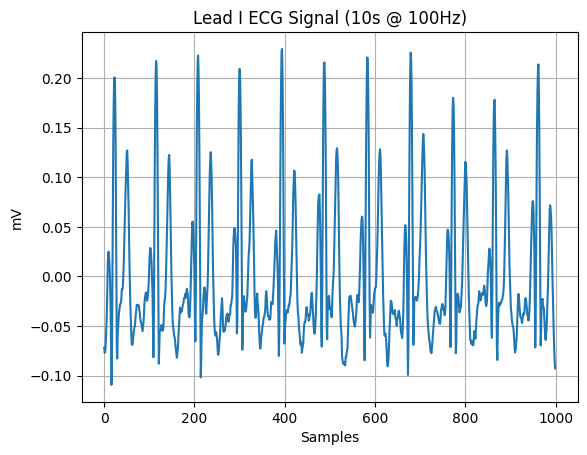

In [ ]:
# Step 4: Signal Processing Function

def preprocess_ecg(record_path):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal.T  # Shape (12, 5000)

    # Denoising (per lead)
    signal_denoised = savgol_filter(signal, window_length=13, polyorder=3, axis=1)
    baseline = savgol_filter(signal_denoised, window_length=301, polyorder=4, axis=1)
    signal_clean = signal_denoised - baseline

    # Downsample from 500Hz to 250Hz
    # signal_downsampled = resample(signal_clean, 1000, axis=1)  # Direct to fixed 250Hz * 10s = 2500 samples
    return signal_clean

import matplotlib.pyplot as plt

test_ecg = preprocess_ecg(df_multiclass['filename_lr'].values[0].replace('.hea', ''))
plt.plot(test_ecg[0])  # Plot lead I
plt.title("Lead I ECG Signal (10s @ 100Hz)")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.grid(True)
plt.show()

# Step 5: Create Dataset

def create_dataset(df, max_per_class=None):
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle
    X, y = [], []
    counts = {"MI": 0, "NORM": 0, "OTHER": 0}
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        label = row["class"]
        if max_per_class and counts[label] >= max_per_class:
            continue
        path = row["filename_lr"].replace(".hea", "")  # Remove .hea extension
        try:
            ecg = preprocess_ecg(path)
            if ecg.shape != (12, 1000):
                print(f"Skipping {path} due to incorrect shape {ecg.shape}")
                continue
            X.append(ecg)
            y.append(["MI", "NORM", "OTHER"].index(label))
            counts[label] += 1
        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue
    print("Final class counts:", counts)
    X = np.array(X)
    y = to_categorical(y, num_classes=3)
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    return X, y


In [ ]:
# Unbalanced
print("Creating unbalanced dataset...")
X_unbal, y_unbal = create_dataset(df_multiclass)

# Balanced
print("Creating balanced dataset...")
X_bal, y_bal = create_dataset(df_multiclass, max_per_class=5000)

Creating unbalanced dataset...


100%|██████████| 21837/21837 [02:25<00:00, 149.94it/s]


Final class counts: {'MI': 5485, 'NORM': 9528, 'OTHER': 6824}
X shape: (21837, 12, 1000)
y shape: (21837, 3)
Creating balanced dataset...


100%|██████████| 21837/21837 [01:54<00:00, 189.96it/s] 


Final class counts: {'MI': 5000, 'NORM': 5000, 'OTHER': 5000}
X shape: (15000, 12, 1000)
y shape: (15000, 3)


In [ ]:
# First: Train+Val (80%) and Test (20%)
# Step 7: Split 60/20/20
X = np.transpose(X_bal, (0, 2, 1))
y = y_bal
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42)

# Then: Train (60%) and Val (20%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp.argmax(axis=1), random_state=42)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (9000, 1000, 12)
Validation shape: (3000, 1000, 12)
Test shape: (3000, 1000, 12)


In [ ]:
print(y_train)
y_train_3classes = df['class']
print(y_train_3classes)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
0         NORM
1         NORM
2         NORM
3         NORM
4         NORM
         ...  
21832    OTHER
21833     NORM
21834    OTHER
21835     NORM
21836     NORM
Name: class, Length: 21837, dtype: object


In [30]:
# === CNN-LSTM BINARY CLASSIFIER ===
def create_binary_model():
    input_layer = Input(shape=(1000, 12))  # ECG shape

    x = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)

    x = Conv1D(32, kernel_size=5, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)

    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)

    output_layer = Dense(2, activation='softmax')(x)  # Binary classification

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def get_meta_features(models, X):
    features = []
    for model in models:
        pred = model.predict(X, verbose=0)
        features.append(pred)
    return np.concatenate(features, axis=1)  # shape: (samples, 6)

# === META CLASSIFIER ===
def create_meta_model(num_classes=3):
    model = Sequential([
        Input(shape=(6,)),  # 3 binary models × 2 probabilities each
        Dense(64, activation='tanh'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='tanh'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



def prepare_binary_dataset(X, y, class_a, class_b):
    idx = np.where((y == class_a) | (y == class_b))[0]
    X_bin = X[idx]
    y_bin = y[idx]
    y_bin = np.where(y_bin == class_a, 0, 1)  # class_a → 0, class_b → 1
    y_bin = to_categorical(y_bin, 2)
    return X_bin, y_bin

def get_meta_features(models, X):
    features = []
    for model in models:
        preds = model.predict(X, verbose=0)  # shape: (samples, 2)
        features.append(preds)
    return np.concatenate(features, axis=1)  # Final shape: (samples, 6)

model = create_meta_model(num_classes=3)
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_47 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,011 (11.76 KB)

 Trainable params: 2,819 (11.01 KB)

 Non-trainable params: 192 (768.00 B)

In [27]:
def prepare_binary_dataset(X, y_onehot, class_a, class_b):
    """
    Extracts a binary dataset from the full one-hot encoded dataset.

    Parameters:
        X: Input samples, shape (N, 1000, 12)
        y_onehot: One-hot labels, shape (N, 3)
        class_a, class_b: The two class indices to compare (e.g., 0 and 2)

    Returns:
        X_binary: Filtered inputs for the 2 classes
        y_binary: One-hot encoded binary labels (N, 2)
    """
    # Convert one-hot → class index (e.g., 0, 1, 2)
    y_class = np.argmax(y_onehot, axis=1)

    # Get only samples of class_a or class_b
    idx = np.where((y_class == class_a) | (y_class == class_b))[0]
    X_bin = X[idx]
    y_bin = y_class[idx]

    # Relabel: class_a → 0, class_b → 1
    y_bin = np.where(y_bin == class_a, 0, 1)

    # Convert to binary one-hot encoding
    y_bin = to_categorical(y_bin, 2)

    return X_bin, y_bin


In [28]:
from keras.callbacks import ModelCheckpoint

# === EARLY STOPPING CALLBACK ===
early_stop = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

# Binary 1: MI (0) vs OTHER (2)
print("Binary classification of class MI vs OTHER")
checkpoint = ModelCheckpoint(
    'best_model1.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)
X1, y1 = prepare_binary_dataset(X_train, y_train, 0, 2)
model1 = create_binary_model()
model1.fit(X1, y1, epochs=50, batch_size=32, validation_split=0.2, callbacks=[checkpoint, early_stop], shuffle=True)

# Binary 2: NORM (1) vs OTHER (2)
print("Binary classification of class NORM vs OTHER")
checkpoint = ModelCheckpoint(
    'best_model2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)
X2, y2 = prepare_binary_dataset(X_train, y_train, 1, 2)
model2 = create_binary_model()
model2.fit(X2, y2, epochs=50, batch_size=32, validation_split=0.2, callbacks=[checkpoint, early_stop], shuffle=True)

# Binary 3: MI (0) vs NORM (1)
print("Binary classification of class MI vs NORM")
checkpoint = ModelCheckpoint(
    'best_model3.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)
X3, y3 = prepare_binary_dataset(X_train, y_train, 0, 1)
model3 = create_binary_model()
model3.fit(X3, y3, epochs=50, batch_size=32, validation_split=0.2, callbacks=[checkpoint, early_stop], shuffle=True)


Binary classification of class MI vs OTHER
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5660 - loss: 0.6828
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step - accuracy: 0.5662 - loss: 0.6827 - val_accuracy: 0.5000 - val_loss: 0.7860
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6397 - loss: 0.6426
Epoch 2: val_accuracy improved from 0.50000 to 0.59333, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 189ms/step - accuracy: 0.6398 - loss: 0.6426 - val_accuracy: 0.5933 - val_loss: 0.7066
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6554 - loss: 0.6300
Epoch 3: val_accuracy did not improve from 0.59333
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 185ms/step - accuracy: 0.6555 - loss: 0.6300 - val_accuracy: 0.5650 - val_loss: 0.7886
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6936 - loss: 0.6028
Epoch 4: val_accuracy improved from 0.59333 to 0.68417, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.6937 - loss: 0.6028 - val_accuracy: 0.6842 - val_loss: 0.6532
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6974 - loss: 0.5938
Epoch 5: val_accuracy improved from 0.68417 to 0.68833, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.6974 - loss: 0.5938 - val_accuracy: 0.6883 - val_loss: 0.5935
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7235 - loss: 0.5695
Epoch 6: val_accuracy improved from 0.68833 to 0.71000, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.7234 - loss: 0.5695 - val_accuracy: 0.7100 - val_loss: 0.6029
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7180 - loss: 0.5734
Epoch 7: val_accuracy improved from 0.71000 to 0.73750, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - accuracy: 0.7181 - loss: 0.5733 - val_accuracy: 0.7375 - val_loss: 0.5666
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7285 - loss: 0.5517
Epoch 8: val_accuracy did not improve from 0.73750
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 190ms/step - accuracy: 0.7284 - loss: 0.5518 - val_accuracy: 0.7242 - val_loss: 0.5830
Epoch 9/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7382 - loss: 0.5522
Epoch 9: val_accuracy did not improve from 0.73750
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 182ms/step - accuracy: 0.7382 - loss: 0.5522 - val_accuracy: 0.7358 - val_loss: 0.5629
Epoch 10/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7314 - loss: 0.5672
Epoch 10: val_accuracy did not improve from 0.73750
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - accuracy: 0.7313 - loss: 0.5672 - val_accuracy: 0.7167 - val_loss: 0.5880
Epoch 11/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7286 - loss: 0.5593
Epoch 11: va

150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - accuracy: 0.7286 - loss: 0.5593 - val_accuracy: 0.7533 - val_loss: 0.5566
Epoch 12/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7403 - loss: 0.5603
Epoch 12: val_accuracy did not improve from 0.75333
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 188ms/step - accuracy: 0.7403 - loss: 0.5602 - val_accuracy: 0.7217 - val_loss: 0.5738
Epoch 13/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7266 - loss: 0.5491
Epoch 13: val_accuracy improved from 0.75333 to 0.75917, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 183ms/step - accuracy: 0.7266 - loss: 0.5491 - val_accuracy: 0.7592 - val_loss: 0.5460
Epoch 14/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7194 - loss: 0.5560
Epoch 14: val_accuracy did not improve from 0.75917
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 195ms/step - accuracy: 0.7195 - loss: 0.5559 - val_accuracy: 0.7450 - val_loss: 0.5786
Epoch 15/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7520 - loss: 0.5201
Epoch 15: val_accuracy did not improve from 0.75917
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 185ms/step - accuracy: 0.7520 - loss: 0.5202 - val_accuracy: 0.7250 - val_loss: 0.5597
Epoch 16/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7442 - loss: 0.5421
Epoch 16: val_accuracy did not improve from 0.75917
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - accuracy: 0.7442 - loss: 0.5421 - val_accuracy: 0.7400 - val_loss: 0.5612
Epoch 17/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7576 - loss: 0.5153
Epoch 17

150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 188ms/step - accuracy: 0.7592 - loss: 0.5131 - val_accuracy: 0.7617 - val_loss: 0.5620
Epoch 24/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7643 - loss: 0.5140
Epoch 24: val_accuracy did not improve from 0.76167
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - accuracy: 0.7643 - loss: 0.5139 - val_accuracy: 0.7217 - val_loss: 0.5859
Epoch 25/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7678 - loss: 0.4963
Epoch 25: val_accuracy improved from 0.76167 to 0.77167, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.7678 - loss: 0.4963 - val_accuracy: 0.7717 - val_loss: 0.5152
Epoch 26/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7664 - loss: 0.5103
Epoch 26: val_accuracy did not improve from 0.77167
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 189ms/step - accuracy: 0.7664 - loss: 0.5103 - val_accuracy: 0.7683 - val_loss: 0.5456
Epoch 27/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7639 - loss: 0.5030
Epoch 27: val_accuracy did not improve from 0.77167
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 189ms/step - accuracy: 0.7640 - loss: 0.5030 - val_accuracy: 0.7633 - val_loss: 0.5295
Epoch 28/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7761 - loss: 0.4901
Epoch 28: val_accuracy did not improve from 0.77167
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.7761 - loss: 0.4901 - val_accuracy: 0.7217 - val_loss: 0.6280
Epoch 29/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7853 - loss: 0.4814
Epoch 29

150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 186ms/step - accuracy: 0.7885 - loss: 0.4700 - val_accuracy: 0.7875 - val_loss: 0.5348
Epoch 35/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7860 - loss: 0.4671
Epoch 35: val_accuracy did not improve from 0.78750
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.7860 - loss: 0.4671 - val_accuracy: 0.7717 - val_loss: 0.6259
Epoch 36/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7870 - loss: 0.4618
Epoch 36: val_accuracy did not improve from 0.78750
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 190ms/step - accuracy: 0.7871 - loss: 0.4618 - val_accuracy: 0.7775 - val_loss: 0.5607
Epoch 37/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8031 - loss: 0.4554
Epoch 37: val_accuracy did not improve from 0.78750
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.8031 - loss: 0.4554 - val_accuracy: 0.7792 - val_loss: 0.5609
Epoch 38/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8053 - loss: 0.4410
Epoch 38

150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - accuracy: 0.8052 - loss: 0.4411 - val_accuracy: 0.7917 - val_loss: 0.4892
Epoch 39/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7996 - loss: 0.4383
Epoch 39: val_accuracy did not improve from 0.79167
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 191ms/step - accuracy: 0.7996 - loss: 0.4383 - val_accuracy: 0.7900 - val_loss: 0.5315
Epoch 40/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8069 - loss: 0.4399
Epoch 40: val_accuracy did not improve from 0.79167
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 185ms/step - accuracy: 0.8069 - loss: 0.4399 - val_accuracy: 0.7733 - val_loss: 0.5826
Epoch 41/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8116 - loss: 0.4256
Epoch 41: val_accuracy did not improve from 0.79167
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.8116 - loss: 0.4257 - val_accuracy: 0.7875 - val_loss: 0.4758
Epoch 42/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8157 - loss: 0.4261
Epoch 42

150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 187ms/step - accuracy: 0.8109 - loss: 0.4237 - val_accuracy: 0.7925 - val_loss: 0.5636
Epoch 49/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8172 - loss: 0.4273
Epoch 49: val_accuracy did not improve from 0.79250
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.8172 - loss: 0.4273 - val_accuracy: 0.7925 - val_loss: 0.5653
Epoch 50/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8142 - loss: 0.4170
Epoch 50: val_accuracy improved from 0.79250 to 0.79500, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.8142 - loss: 0.4170 - val_accuracy: 0.7950 - val_loss: 0.4812
Restoring model weights from the end of the best epoch: 41.
Binary classification of class NORM vs OTHER
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7104 - loss: 0.5701
Epoch 1: val_accuracy improved from -inf to 0.49250, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 189ms/step - accuracy: 0.7107 - loss: 0.5697 - val_accuracy: 0.4925 - val_loss: 1.3784
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8115 - loss: 0.4351
Epoch 2: val_accuracy improved from 0.49250 to 0.51583, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 185ms/step - accuracy: 0.8115 - loss: 0.4351 - val_accuracy: 0.5158 - val_loss: 1.0405
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8193 - loss: 0.4482
Epoch 3: val_accuracy improved from 0.51583 to 0.64250, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 189ms/step - accuracy: 0.8193 - loss: 0.4481 - val_accuracy: 0.6425 - val_loss: 0.8112
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8277 - loss: 0.3934
Epoch 4: val_accuracy improved from 0.64250 to 0.79167, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 187ms/step - accuracy: 0.8277 - loss: 0.3934 - val_accuracy: 0.7917 - val_loss: 0.5519
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8438 - loss: 0.3768
Epoch 5: val_accuracy improved from 0.79167 to 0.83250, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.8439 - loss: 0.3768 - val_accuracy: 0.8325 - val_loss: 0.3997
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8492 - loss: 0.3687
Epoch 6: val_accuracy did not improve from 0.83250
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - accuracy: 0.8492 - loss: 0.3687 - val_accuracy: 0.8233 - val_loss: 0.4608
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8544 - loss: 0.3586
Epoch 7: val_accuracy did not improve from 0.83250
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 0.8543 - loss: 0.3587 - val_accuracy: 0.8200 - val_loss: 0.5037
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8540 - loss: 0.3642
Epoch 8: val_accuracy improved from 0.83250 to 0.83917, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 185ms/step - accuracy: 0.8540 - loss: 0.3642 - val_accuracy: 0.8392 - val_loss: 0.4174
Epoch 9/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8520 - loss: 0.3557
Epoch 9: val_accuracy improved from 0.83917 to 0.84167, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 188ms/step - accuracy: 0.8521 - loss: 0.3557 - val_accuracy: 0.8417 - val_loss: 0.4133
Epoch 10/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8568 - loss: 0.3574
Epoch 10: val_accuracy improved from 0.84167 to 0.84917, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 185ms/step - accuracy: 0.8569 - loss: 0.3574 - val_accuracy: 0.8492 - val_loss: 0.3613
Epoch 11/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8516 - loss: 0.3644
Epoch 11: val_accuracy did not improve from 0.84917
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 185ms/step - accuracy: 0.8517 - loss: 0.3643 - val_accuracy: 0.8475 - val_loss: 0.3790
Epoch 12/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8713 - loss: 0.3258
Epoch 12: val_accuracy improved from 0.84917 to 0.85333, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.8712 - loss: 0.3259 - val_accuracy: 0.8533 - val_loss: 0.3329
Epoch 13/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8515 - loss: 0.3444
Epoch 13: val_accuracy did not improve from 0.85333
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - accuracy: 0.8515 - loss: 0.3444 - val_accuracy: 0.8392 - val_loss: 0.4262
Epoch 14/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8608 - loss: 0.3369
Epoch 14: val_accuracy improved from 0.85333 to 0.85917, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 181ms/step - accuracy: 0.8608 - loss: 0.3369 - val_accuracy: 0.8592 - val_loss: 0.3890
Epoch 15/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8701 - loss: 0.3228
Epoch 15: val_accuracy did not improve from 0.85917
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 186ms/step - accuracy: 0.8701 - loss: 0.3229 - val_accuracy: 0.8400 - val_loss: 0.3551
Epoch 16/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8548 - loss: 0.3304
Epoch 16: val_accuracy did not improve from 0.85917
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.8549 - loss: 0.3304 - val_accuracy: 0.8458 - val_loss: 0.3625
Epoch 17/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8709 - loss: 0.3277
Epoch 17: val_accuracy did not improve from 0.85917
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.8708 - loss: 0.3277 - val_accuracy: 0.8592 - val_loss: 0.3711
Epoch 18/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8715 - loss: 0.3197
Epoch 18

150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - accuracy: 0.8715 - loss: 0.3198 - val_accuracy: 0.8617 - val_loss: 0.3493
Epoch 19/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8741 - loss: 0.3167
Epoch 19: val_accuracy improved from 0.86167 to 0.87000, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 183ms/step - accuracy: 0.8741 - loss: 0.3168 - val_accuracy: 0.8700 - val_loss: 0.3373
Epoch 20/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8637 - loss: 0.3262
Epoch 20: val_accuracy did not improve from 0.87000
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 191ms/step - accuracy: 0.8637 - loss: 0.3262 - val_accuracy: 0.8483 - val_loss: 0.3951
Epoch 21/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8645 - loss: 0.3085
Epoch 21: val_accuracy did not improve from 0.87000
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 190ms/step - accuracy: 0.8645 - loss: 0.3086 - val_accuracy: 0.8500 - val_loss: 0.4358
Epoch 22/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8612 - loss: 0.3231
Epoch 22: val_accuracy did not improve from 0.87000
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 193ms/step - accuracy: 0.8612 - loss: 0.3231 - val_accuracy: 0.8525 - val_loss: 0.3461
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
Binary class

150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 189ms/step - accuracy: 0.7478 - loss: 0.5323 - val_accuracy: 0.4925 - val_loss: 1.3389
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8370 - loss: 0.4112
Epoch 2: val_accuracy improved from 0.49250 to 0.49833, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 185ms/step - accuracy: 0.8369 - loss: 0.4112 - val_accuracy: 0.4983 - val_loss: 1.2938
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8409 - loss: 0.3869
Epoch 3: val_accuracy improved from 0.49833 to 0.64333, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - accuracy: 0.8409 - loss: 0.3869 - val_accuracy: 0.6433 - val_loss: 0.8478
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8403 - loss: 0.3778
Epoch 4: val_accuracy improved from 0.64333 to 0.74750, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 185ms/step - accuracy: 0.8403 - loss: 0.3777 - val_accuracy: 0.7475 - val_loss: 0.6820
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8484 - loss: 0.3606
Epoch 5: val_accuracy improved from 0.74750 to 0.82667, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.8484 - loss: 0.3606 - val_accuracy: 0.8267 - val_loss: 0.4241
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8600 - loss: 0.3688
Epoch 6: val_accuracy improved from 0.82667 to 0.84167, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.8600 - loss: 0.3687 - val_accuracy: 0.8417 - val_loss: 0.4130
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8691 - loss: 0.3329
Epoch 7: val_accuracy did not improve from 0.84167
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 0.8690 - loss: 0.3330 - val_accuracy: 0.8367 - val_loss: 0.5751
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8641 - loss: 0.3511
Epoch 8: val_accuracy improved from 0.84167 to 0.85167, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.8641 - loss: 0.3511 - val_accuracy: 0.8517 - val_loss: 0.3674
Epoch 9/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8518 - loss: 0.3455
Epoch 9: val_accuracy did not improve from 0.85167
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - accuracy: 0.8519 - loss: 0.3455 - val_accuracy: 0.8133 - val_loss: 0.4941
Epoch 10/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8679 - loss: 0.3538
Epoch 10: val_accuracy improved from 0.85167 to 0.86917, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 186ms/step - accuracy: 0.8679 - loss: 0.3537 - val_accuracy: 0.8692 - val_loss: 0.3412
Epoch 11/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8704 - loss: 0.3273
Epoch 11: val_accuracy did not improve from 0.86917
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.8704 - loss: 0.3274 - val_accuracy: 0.8192 - val_loss: 0.4032
Epoch 12/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8704 - loss: 0.3228
Epoch 12: val_accuracy did not improve from 0.86917
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.8704 - loss: 0.3228 - val_accuracy: 0.8092 - val_loss: 0.5356
Epoch 13/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8491 - loss: 0.3586
Epoch 13: val_accuracy did not improve from 0.86917
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 190ms/step - accuracy: 0.8492 - loss: 0.3584 - val_accuracy: 0.8167 - val_loss: 0.4236
Epoch 14/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8588 - loss: 0.3240
Epoch 14

150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.8661 - loss: 0.3254 - val_accuracy: 0.8733 - val_loss: 0.3481
Epoch 16/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8650 - loss: 0.3345
Epoch 16: val_accuracy did not improve from 0.87333
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - accuracy: 0.8651 - loss: 0.3344 - val_accuracy: 0.8208 - val_loss: 0.3867
Epoch 17/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8701 - loss: 0.3221
Epoch 17: val_accuracy did not improve from 0.87333
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.8701 - loss: 0.3221 - val_accuracy: 0.8350 - val_loss: 0.3938
Epoch 18/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8755 - loss: 0.3079
Epoch 18: val_accuracy did not improve from 0.87333
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 185ms/step - accuracy: 0.8755 - loss: 0.3079 - val_accuracy: 0.8425 - val_loss: 0.4274
Epoch 19/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8789 - loss: 0.3202
Epoch 19

150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 188ms/step - accuracy: 0.8802 - loss: 0.2928 - val_accuracy: 0.8750 - val_loss: 0.3225
Epoch 24/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8786 - loss: 0.2992
Epoch 24: val_accuracy did not improve from 0.87500
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 183ms/step - accuracy: 0.8787 - loss: 0.2992 - val_accuracy: 0.8600 - val_loss: 0.3373
Epoch 25/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8796 - loss: 0.3069
Epoch 25: val_accuracy did not improve from 0.87500
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - accuracy: 0.8796 - loss: 0.3069 - val_accuracy: 0.8475 - val_loss: 0.3480
Epoch 26/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8767 - loss: 0.2941
Epoch 26: val_accuracy did not improve from 0.87500
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 181ms/step - accuracy: 0.8767 - loss: 0.2941 - val_accuracy: 0.8600 - val_loss: 0.3163
Epoch 27/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8813 - loss: 0.2999
Epoch 27

150/150 ━━━━━━━━━━━━━━━━━━━━ 44s 204ms/step - accuracy: 0.8959 - loss: 0.2591 - val_accuracy: 0.8783 - val_loss: 0.2758
Epoch 44/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8931 - loss: 0.2525
Epoch 44: val_accuracy did not improve from 0.87833
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 182ms/step - accuracy: 0.8932 - loss: 0.2525 - val_accuracy: 0.8608 - val_loss: 0.3335
Epoch 45/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9044 - loss: 0.2413
Epoch 45: val_accuracy did not improve from 0.87833
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - accuracy: 0.9043 - loss: 0.2414 - val_accuracy: 0.8750 - val_loss: 0.3088
Epoch 46/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8997 - loss: 0.2573
Epoch 46: val_accuracy did not improve from 0.87833
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.8997 - loss: 0.2573 - val_accuracy: 0.8650 - val_loss: 0.3445
Epoch 47/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9011 - loss: 0.2670
Epoch 47

150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.8946 - loss: 0.2485 - val_accuracy: 0.8808 - val_loss: 0.2965
Restoring model weights from the end of the best epoch: 43.


In [31]:
# 7. Train Meta-Classifier on Full 3-Class Data
model1.load_weights('best_model1.h5')
model2.load_weights('best_model2.h5')
model3.load_weights('best_model3.h5')


X_meta_train = get_meta_features([model1, model2, model3], X_train)
meta_model = create_meta_model(num_classes=3)
history = meta_model.fit(X_meta_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7427 - loss: 0.6688 - val_accuracy: 0.7456 - val_loss: 0.6291
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7721 - loss: 0.6007 - val_accuracy: 0.7483 - val_loss: 0.6253
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7865 - loss: 0.5636 - val_accuracy: 0.7489 - val_loss: 0.6359
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7753 - loss: 0.5800 - val_accuracy: 0.7467 - val_loss: 0.6493
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7865 - loss: 0.5595 - val_accuracy: 0.7439 - val_loss: 0.6245
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7872 - loss: 0.5513 - val_accuracy: 0.7461 - val_loss: 0.6327
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7796 - loss: 0.5602 - val_accuracy: 0.7444 - val_loss: 0.6304
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7813 - loss: 0.5543 - val_accuracy: 0.

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test Accuracy: 0.7583333333333333
              precision    recall  f1-score   support

          MI       0.77      0.70      0.74      1000
        NORM       0.80      0.85      0.82      1000
       OTHER       0.71      0.72      0.71      1000

    accuracy                           0.76      3000
   macro avg       0.76      0.76      0.76      3000
weighted avg       0.76      0.76      0.76      3000



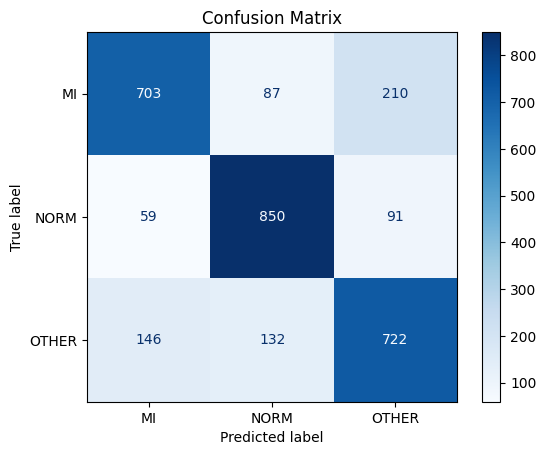

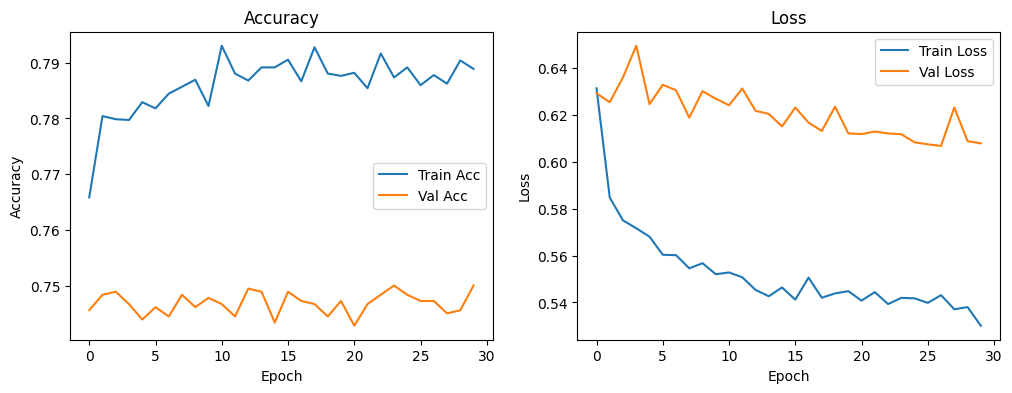

In [32]:
from sklearn.metrics import accuracy_score, classification_report
# Get predictions
X_meta_test = get_meta_features([model1, model2, model3], X_test)
y_pred = np.argmax(meta_model.predict(X_meta_test), axis=1)

from sklearn.metrics import classification_report, accuracy_score

# Convert one-hot to integer labels
y_test_labels = np.argmax(y_test, axis=1)

print("Test Accuracy:", accuracy_score(y_test_labels, y_pred))
print(classification_report(y_test_labels, y_pred, target_names=["MI", "NORM", "OTHER"]))

# Step 12: Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["MI", "NORM", "OTHER"]).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Step 13: Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Step 11: Classification Report
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["MI", "NORM", "OTHER"]))

# Step 12: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["MI", "NORM", "OTHER"]).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Step 13: Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
